In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import csv
import os

### Import Features

In [24]:
# filename = 'relevant_features/calculated_features_standardized.csv'
filename = 'relevant_features/calculated_relevantFeatures_2_standardized.csv'

calculated_features = pd.read_csv(filename)
calculated_features

,Unnamed: 0,label,"value_norm__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""max""","value_norm__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""mean""","value_norm__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""min""","value_norm__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""max""","value_norm__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""mean""","value_norm__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""max""","value_norm__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""mean""","value_norm__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""min""",...,"value_norm__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""max""","value_norm__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""mean""","value_norm__agg_linear_trend__attr_""slope""__chunk_len_5__f_agg_""max""","value_norm__agg_linear_trend__attr_""slope""__chunk_len_5__f_agg_""mean""","value_norm__agg_linear_trend__attr_""slope""__chunk_len_5__f_agg_""min""","value_norm__fft_coefficient__attr_""imag""__coeff_1",value_norm__fourier_entropy__bins_3,"value_norm__linear_trend__attr_""intercept""","value_norm__linear_trend__attr_""rvalue""","value_norm__linear_trend__attr_""slope"""
0,HF2460_WAV_004cleanforms_0,pah,0.311058,0.202768,0.097830,0.793982,0.183641,0.252698,0.204918,0.157624,...,-0.096772,-0.040809,-0.004528,-0.004140,-0.003758,-75.372953,0.045395,0.206600,-0.119639,-0.000828
1,HF2460_WAV_004cleanforms_1,pah,0.126251,0.079129,0.032112,0.326440,0.072759,0.100883,0.079928,0.059003,...,-0.013582,-0.016169,-0.001597,-0.001615,-0.001633,-17.405792,0.090729,0.080571,-0.046657,-0.000323
2,HF2460_WAV_004cleanforms_2,pah,0.476660,0.425795,0.375038,0.668862,0.393095,0.452772,0.430075,0.407514,...,-0.090904,-0.087354,-0.008720,-0.008688,-0.008659,-112.100633,0.045395,0.433529,-0.251050,-0.001738
3,HF2460_WAV_004cleanforms_3,pah,0.287064,0.232150,0.176849,0.509276,0.215912,0.258905,0.234431,0.209813,...,-0.053527,-0.047980,-0.004788,-0.004736,-0.004682,-86.596480,0.045395,0.236297,-0.136836,-0.000947
4,HF2460_WAV_004cleanforms_4,pah,0.275722,0.220131,0.164396,0.500080,0.204637,0.247096,0.222291,0.197626,...,-0.052401,-0.045475,-0.004555,-0.004491,-0.004429,-84.053613,0.045395,0.224059,-0.129750,-0.000898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,HJ7804_WAV_004cleanforms_3,pah,0.159991,0.125926,0.092216,0.298492,0.115876,0.142254,0.127207,0.112181,...,-0.009223,-0.025750,-0.002440,-0.002570,-0.002700,-0.784394,0.045395,0.128235,-0.074259,-0.000514
152,HJ7804_WAV_004cleanforms_4,pah,0.165302,0.126063,0.087233,0.337957,0.116926,0.144609,0.127306,0.109815,...,-0.017993,-0.025984,-0.002481,-0.002572,-0.002661,-21.946286,0.045395,0.128322,-0.074309,-0.000514
153,HJ7804_WAV_004cleanforms_5,pah,0.190723,0.134763,0.077475,0.429203,0.126506,0.161264,0.136042,0.110928,...,-0.037096,-0.028112,-0.002812,-0.002748,-0.002686,-51.171087,0.045395,0.137111,-0.079399,-0.000550
154,HJ7804_WAV_004cleanforms_6,pah,0.365761,0.312889,0.259764,0.574933,0.290562,0.339559,0.315979,0.292475,...,-0.073736,-0.064569,-0.006456,-0.006383,-0.006311,-102.540323,0.045395,0.318500,-0.184439,-0.001277


### Export Summary Statistics (if wanted)

In [94]:
is_export = False
filename = 'test_statistics.csv'

if is_export:
    calculated_features[[col for col in calculated_features.columns if 'value' in col]].describe().transpose().to_csv(filename)

### Box and Whisker of Selected Feature

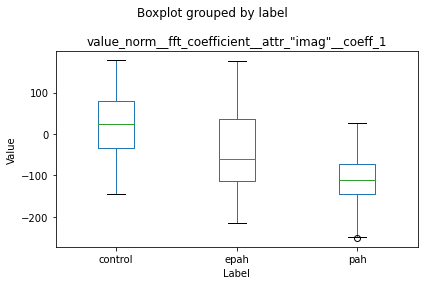

In [95]:
feature = 'value_norm__fft_coefficient__attr_"imag"__coeff_1'

calculated_features[['label', feature]].groupby('label').describe()

calculated_features.boxplot(column=feature, by='label', grid=False)
plt.ylabel('Value')
plt.xlabel('Label')
plt.tight_layout()

### One-Way ANOVA

In [32]:
import statsmodels.api as sm
from patsy import dmatrices

from statsmodels.formula.api import ols

feature = 'value_norm__fft_coefficient__attr_"imag"__coeff_1'

model = ols('Q(feature) ~ C(label)', data=calculated_features).fit()
anova_table = sm.stats.anova_lm(model, typ=3)
anova_table

,sum_sq,df,F,PR(>F)
Intercept,1.038960e+04,1.0,1.561585,2.133415e-01
C(label),3.850700e+05,2.0,28.938531,2.191037e-11
Residual,1.017946e+06,153.0,NaN,NaN


### Post Hoc Tests

In [44]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(calculated_features[feature], calculated_features['label'])
tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
control,epah,-61.6461,0.0023,-104.2594,-19.0328,True
control,pah,-133.0971,0.001,-176.1493,-90.0449,True
epah,pah,-71.451,0.001,-105.8673,-37.0347,True


### Testing ANOVA Assumptions

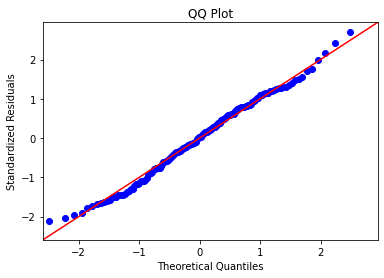

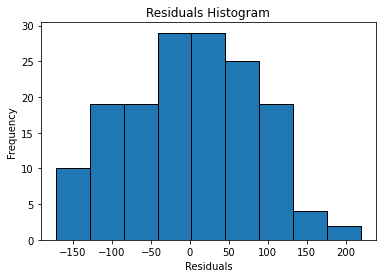

Jarque-Bera:  1.7237887037451516
p-value:      0.42236122322865965
Reject:       False
    ==> Data ARE normally distributed

Bartlett:     0.8546564256108385
p-value:      0.6522494404740216
Reject:       False
    ==> Sample populations HAVE equal variances



In [96]:
from statsmodels.stats.stattools import jarque_bera
import scipy.stats as stats

influence = model.get_influence()

# QQ Plot
sm.qqplot(influence.resid_studentized_internal, line='45')
plt.title('QQ Plot')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Standardized Residuals')
plt.show()

# Histogram
plt.hist(model.resid, bins='auto', histtype='bar', ec='k')
plt.title('Residuals Histogram')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Jarque-Bera tests the null that data are normally distributed
# aka, if p < 0.05, then reject null --> data are NOT normally distributed
# We want p > 0.05
name = ['Jarque-Bera', 'PValue', 'Skew', 'Kurtosis']
test = jarque_bera(model.resid)
reject = test[1] < 0.05
print(f'Jarque-Bera:  {test[0]}')
print(f'p-value:      {test[1]}')
# print(f'Skew:         {test[2]}')
# print(f'Kurtosis:     {test[3]}')
print(f'Reject:       {reject}')
print('    ==> Data ARE ' + ('NOT ' if reject else '') + 'normally distributed')
print()

# Bartlett tests the null that all input samples are from populations with equal variances
# aka, if p < 0.05, then reject null --> samples are NOT from populations with equal variances
# We want p > 0.05
w, pvalue = stats.bartlett(*list(calculated_features[['label', feature]].groupby('label', group_keys=False).groups.values()))
reject = pvalue < 0.05
print(f'Bartlett:     {w}')
print(f'p-value:      {pvalue}')
print(f'Reject:       {reject}')
print('    ==> Sample populations ' + ('DO NOT ' if reject else '') + 'HAVE equal variances')
print()